In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

In [18]:
from utils import *
dataset_name1 = "hopper-medium-replay-v2"
dataset1, env_info = get_dataset(dataset_name1)
env_name = env_info['env_name']
state_dim = env_info['state_dim']
act_dim = env_info['action_dim']

/home/prajwal/workfolder/SAC-X-DT/.conda/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/home/prajwal/workfolder/SAC-X-DT/.conda/lib/python3.10/site-packages/gym/envs/mujoco/mujoco_env.py:191: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
load datafile: 100%|██████████| 11/11 [00:00<00:00, 33.85it/s]


In [19]:
dataset_name2 = "hopper-expert-v2"
dataset2, _ = get_dataset(dataset_name2)

load datafile: 100%|██████████| 21/21 [00:00<00:00, 28.95it/s]


In [20]:
dataset1.keys()

dict_keys(['actions', 'infos/action_log_probs', 'infos/qpos', 'infos/qvel', 'metadata/algorithm', 'metadata/iteration', 'next_observations', 'observations', 'rewards', 'terminals', 'timeouts'])

In [21]:
dataset1_obs = np.concatenate([dataset1['infos/qpos'], dataset1['infos/qvel']], axis=1)
dataset2_obs = np.concatenate([dataset2['infos/qpos'], dataset2['infos/qvel']], axis=1)

In [22]:
observations = np.concatenate((dataset1_obs, dataset2_obs), axis=0)
actions = np.concatenate((dataset1['actions'], dataset2['actions']), axis=0)
next_observations = np.concatenate((dataset1['next_observations'], dataset2['next_observations']), axis=0)

In [23]:
next_observations = np.roll(observations, -1, axis=0)

In [24]:
mask = ~np.concatenate((dataset1['terminals']+dataset1['timeouts'], dataset2['terminals']+dataset2['timeouts']), axis=0)

In [25]:
observations = np.array(observations[mask], dtype=np.float32)
actions = np.array(actions[mask], dtype=np.float32)
next_observations = np.array(next_observations[mask], dtype=np.float32)

In [26]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, observations, actions, next_observations):
        self.obs_dim = observations.shape[1]
        self.act_dim = actions.shape[1]
        self.input_obs_act = np.concatenate((observations, actions), axis=1)
        self.next_observations = next_observations

    def __len__(self):
        return len(self.input_obs_act)

    def __getitem__(self, idx):
        return (self.input_obs_act[idx], self.next_observations[idx])

In [27]:
class Dynamics(nn.Module):
    def __init__(self, state_dim, act_dim, model_size=[256, 256], NStep=10):
        super(Dynamics, self).__init__()
        self.state_dim = state_dim
        self.act_dim = act_dim
        self.model_size = model_size
        self.fc1 = nn.Linear(state_dim + act_dim, model_size[0])
        self.fc2 = nn.Linear(model_size[0], model_size[1])
        self.fc3 = nn.Linear(model_size[1], state_dim)
        self.model_seq = nn.Sequential(self.fc1, nn.ReLU(), 
                                       self.fc2, nn.ReLU(), 
                                       self.fc3)
        self.NStep = NStep

    def forward(self, x):
        for i in range(self.NStep):
            v = self.model_seq(x)
            next_state = x[:, :self.state_dim] + v
            x = torch.cat((next_state, x[:, self.state_dim:]), dim=1)
        return x[:, :self.state_dim]
    
    def predict(self, obs, act):
        x = torch.cat((obs, act), dim=1)
        return self.forward(x)

In [28]:
hopper_dataset = dataset(observations, actions, next_observations)
train_size = int(0.8 * len(hopper_dataset))
test_size = len(hopper_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(hopper_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [29]:
len(hopper_dataset), len(train_dataset), len(test_dataset)

(1398932, 1119145, 279787)

In [30]:
model = Dynamics(state_dim=observations.shape[1], act_dim=actions.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [31]:
# initial mse loss on test set
test_loss = 0
model.eval()
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs = inputs.float()
    labels = labels.float()
    outputs = model(inputs)
    test_loss += criterion(outputs, labels).item()
test_loss /= len(test_loader)
print(f"Initial test loss: {test_loss}")


Initial test loss: 12.305607441468513


In [32]:
batch_size=256
epochs=10
lr=1e-3
training_losses = []
test_losses = []
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('Epoch: {}, Training Loss (Epoch): {:.4f}, Training Loss (Last Batch): {:.4f}, Time: {:.2f}'.format(epoch+1, train_loss, loss.item(), time.time()-start_time))
    training_losses.append(train_loss)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
    print('Test Loss: {:.4f}'.format(test_loss))
    print('Time Alloted: {:.2f}'.format(time.time()-start_time))
    print('-----'*10)

Epoch: 1, Training Loss (Epoch): 0.0515, Training Loss (Last Batch): 0.0200, Time: 55.17
Test Loss: 0.0205
Time Alloted: 57.06
--------------------------------------------------
Epoch: 2, Training Loss (Epoch): 0.0143, Training Loss (Last Batch): 0.0083, Time: 56.77
Test Loss: 0.0096
Time Alloted: 60.58
--------------------------------------------------
Epoch: 3, Training Loss (Epoch): 0.0091, Training Loss (Last Batch): 0.0070, Time: 59.39
Test Loss: 0.0069
Time Alloted: 61.47
--------------------------------------------------
Epoch: 4, Training Loss (Epoch): 0.0071, Training Loss (Last Batch): 0.0050, Time: 61.03
Test Loss: 0.0058
Time Alloted: 64.84
--------------------------------------------------
Epoch: 5, Training Loss (Epoch): 0.0059, Training Loss (Last Batch): 0.0031, Time: 61.04
Test Loss: 0.0057
Time Alloted: 64.87
--------------------------------------------------
Epoch: 6, Training Loss (Epoch): 0.0054, Training Loss (Last Batch): 0.0039, Time: 60.13
Test Loss: 0.0052
Tim

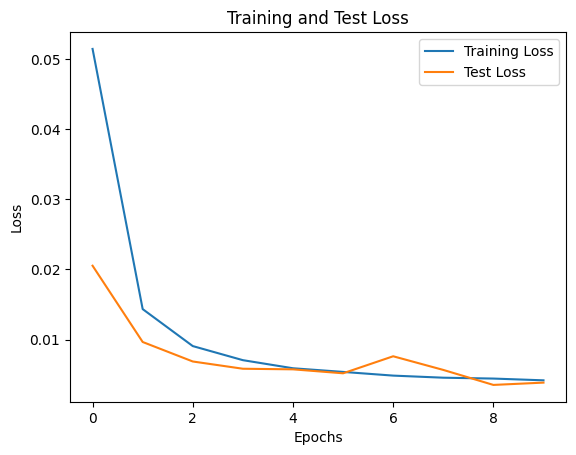

In [33]:
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.show()

In [34]:
test_dataset_name = "hopper-random-v2"
test_dataset, env_info = get_dataset(test_dataset_name)

load datafile: 100%|██████████| 9/9 [00:00<00:00, 12.02it/s]


In [35]:
rand_obs = np.concatenate([test_dataset['infos/qpos'], test_dataset['infos/qvel']], axis=1)
rand_act = test_dataset['actions']
rand_next_obs = test_dataset['next_observations']

In [36]:
pred_next_obs = model.predict(torch.tensor(rand_obs).float(), torch.tensor(rand_act).float()).detach().numpy()
mse = np.mean((pred_next_obs[:,1:] - rand_next_obs)**2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.009580123238265514


In [37]:
test_dataset_name = "hopper-medium-v2"
test_dataset, env_info = get_dataset(test_dataset_name)

load datafile: 100%|██████████| 21/21 [00:00<00:00, 27.52it/s]


In [38]:
expert_obs = np.concatenate([test_dataset['infos/qpos'], test_dataset['infos/qvel']], axis=1)
expert_act = test_dataset['actions']
expert_next_obs = test_dataset['next_observations']

In [39]:
pred_next_obs = model.predict(torch.tensor(expert_obs).float(), torch.tensor(expert_act).float()).detach().numpy()
mse = np.mean((pred_next_obs[:,1:] - expert_next_obs)**2)
print(f"MSE: {mse}")

MSE: 0.006783456075936556


In [40]:
torch.save(model, './TrainedModels/multistep_flow_dynamics_hopper.pth')